# TP4 : Compression d’un Signal Audio

Réalisé par
+ Lisa TOUZARI
+ Anis NEHMAR

Groupe
+ ISI 2b

In [1]:
# importer les bibliothèques utiles dans ce tp
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import math
import numpy as np
import cmath
from IPython.display import display, Audio
from numpy import nan


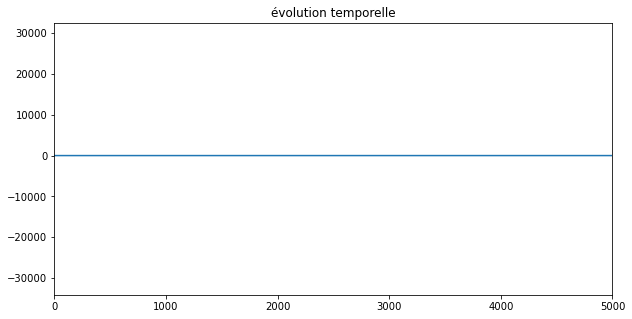

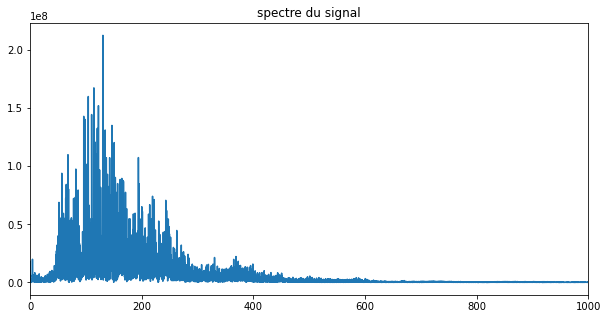

In [2]:
# définition de la fonction tfct
def tfct (path,N_win,N_hop,N_fft):
    #chargement du signal audio
    x = wav.read(path)
    Fe = x[0]
    Te = 1/Fe
    x_vect = x[1]
    
    H = np.hamming(N_win)
    
    #isoler et tracer l'allure tomporelle d'une trame 
    nbr_trames=int((len(x_vect)-N_win)/N_hop +1)
    
    x_trames = np.zeros((nbr_trames,N_win),dtype=complex)
    t = np.zeros((nbr_trames,N_win))

    for k in range(0,nbr_trames):
        x_trames[k,:] = x_vect[k*N_hop:k*N_hop +N_win]*H


    for k in range(0,nbr_trames):
        t[k,:] = np.arange(k*N_win*Te,(k+1)*N_win*Te,Te)[0:N_win]# axe de temps
    
   
    
    #la matrice de tfct
    f = np.fft.fftfreq(N_fft,Te)
    #f=np.linspace(0,Fe,N_fft)
    nl=math.floor(N_fft/2+1)
    #print(nl)
    x_mat = np.zeros((nl,nbr_trames),dtype=complex)
    
    for i in range(nbr_trames):
        x= np.fft.fft(x_trames[i],n=N_fft)
        x_mat[:,i] = x[0:nl]       
        
    return x_mat,f,t

# test de la fct tfct sur le signal daftPunk_aroundTheWorld.wav
x = wav.read('daftPunk_aroundTheWorld.wav')
Fe = x[0]
Te = 1/Fe
y = x[1]

plt.figure(figsize=(10,5))
plt.plot(y)
plt.title('évolution temporelle')
plt.xlim(0,5000)

N_win=10024
N_hop= int (N_win/4)
N_fft=N_win

f = np.fft.fftfreq(len(y),Te)
spectre = np.fft.fft(y)
plt.figure(figsize=(10,5))
plt.plot(np.fft.fftshift(f), abs(np.fft.fftshift(spectre)))
plt.title('spectre du signal')
plt.xlim(0,1000)
x_tfct,f,t=tfct('daftPunk_aroundTheWorld.wav',N_win,N_hop,N_fft)


<ipython-input-3-05aa83dbcf94>:15: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(abs(x_mat)), aspect="auto", extent=(0,len(y)/Fe,0,Fe/2))


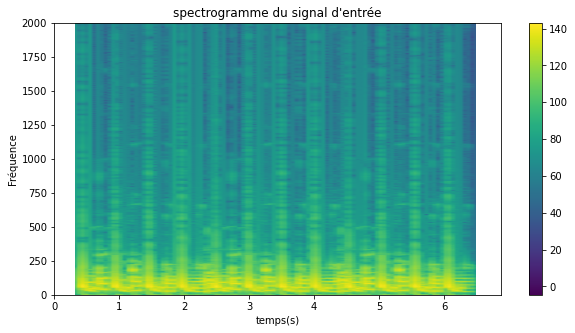

In [3]:
C=x_tfct.shape[1] # nombre de colonnes 
L=x_tfct.shape[0] # nombre de lignes   
    
# completer la matrice tfct
x_mat=np.zeros((N_win,C),dtype=complex)

for i in range(C):
    x_mat[0:L,i]=x_tfct[:,i]
  
for j in range (C):
    for i  in range(1,L):
        x_mat[-i,j]=x_tfct[i-1,j].conjugate()

plt.figure(figsize=(10,5))
plt.imshow(20*np.log10(abs(x_mat)), aspect="auto", extent=(0,len(y)/Fe,0,Fe/2))    
plt.title("spectrogramme du signal d'entrée")
plt.xlabel("temps(s)")
plt.ylabel("Fréquence")
plt.colorbar()
plt.ylim(0,2000)

display(Audio(y,rate=Fe))

<ipython-input-4-e1a0e0216f29>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i]=np.max(x[:,i])
<ipython-input-4-e1a0e0216f29>:9: RuntimeWarning: invalid value encountered in true_divide
  x_norm[:,i]= x[:,i]/np.max(x[:,i])


110264


Text(0, 0.5, 'An')

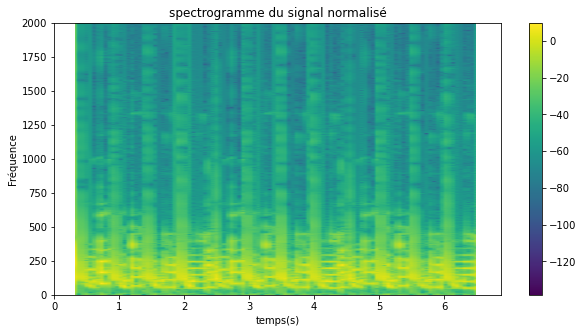

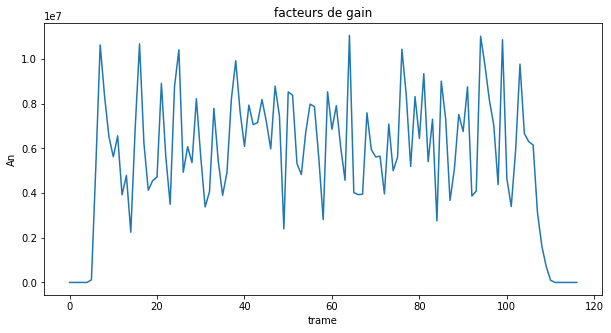

In [4]:
x=np.zeros((N_win,C),dtype=complex)
x=x_mat
#normalisation
x_norm=np.zeros((N_win,C),dtype=complex)
A=np.zeros(x.shape[1])

for i in range (len(x[0,:])): 
  A[i]=np.max(x[:,i]) 
  x_norm[:,i]= x[:,i]/np.max(x[:,i])
  
plt.figure(figsize=(10,5))
plt.imshow(20*np.log10(abs(x_norm)), aspect="auto", extent=(0,len(y)/Fe,0,Fe))    
plt.title("spectrogramme du signal normalisé")
plt.xlabel("temps(s)")
plt.ylabel("Fréquence")
plt.colorbar()
plt.ylim(0,2000)
# supprimer les valeurs non définies 
cmt=0
for i in range(len(x_norm[:,0])):
  for j in range(len(x_norm[0,:])):
    if cmath.isnan(x_norm[i,j]):
      x_norm[i,j]=1e-10
      cmt=cmt+1
print(cmt)

plt.figure(figsize=(10,5))
plt.plot(A) 
plt.title("facteurs de gain")
plt.xlabel("trame")
plt.ylabel("An")



In [5]:
# calcul du nombre de bits par trame
debit = 392*(10**3)
trame_seconde = Fe/N_hop  #---nombre de trames par seconde
trame_seconde = trame_seconde + 1
bits_trame = int(debit / trame_seconde) # nombre de bit par trame
print(f"nombre des bits = {bits_trame}") 

bits_point_fréq= int(bits_trame/N_win) # nombre de bit par point fréquentiel
print(f"nombre des bits par point = {bits_point_fréq}") 

nombre des bits = 21077
nombre des bits par point = 2


In [6]:
# algorithme de compression de son 

SMR = 20*np.log10(abs(x_norm+10**(-9)))+96
SNR = 0
NMR = SMR -SNR

Q = np.zeros((x_norm.shape[0],x_norm.shape[1])) 
NMR_1 = NMR
for i in range(NMR.shape[1]): #par trame
    R = bits_trame
    indice_max = np.argmax(NMR_1[:,i])    
    while ( R>0 and not (all(NMR_1[:,i]<0))):

      if (Q[indice_max,i]<=16):              
        indice_max = np.argmax(NMR_1[:,i])
        NMR_1[indice_max,i]-=6
        NMR[indice_max,i]-= 6
        Q[indice_max,i]=Q[indice_max,i]+ 1
        R = R - 1
            
      else:
        NMR_1[indice_max,i] = np.min(NMR_1[:,i])-100000
        indice_max = np.argmax(NMR_1[:,i])
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


In [292]:
def Fuquant(x, N):
# quantificateur uniforme sur n bits
# saturation  +-1
# entrée: vecteur de reels
# sortie: vecteur d'entiers positifs

    if N>0:
        pown = 2**(N-1)
        xq = pown*(x<0) + np.floor( pown *np.min([np.abs(x),1-1e-10]) )
    else:
        # xq = []
        xq = 0      

    return xq

In [293]:
Xq = np.zeros((x_norm.shape[0],x_norm.shape[1]))
for i in range (x_norm.shape[0]):
    for j in range(x_norm.shape[1]):
        Xq[i,j] = Fuquant(abs(x_norm[i,j]),Q[i,j])

cmt=0
for i in range(len(Xq[:,0])):
  for j in range(len(Xq[0,:])):
    if cmath.isnan(Xq[i,j]):
      #Xq[i,j]=1-1e-10
      cmt=cmt+1

print(cmt)

0


(0.0, 2000.0)

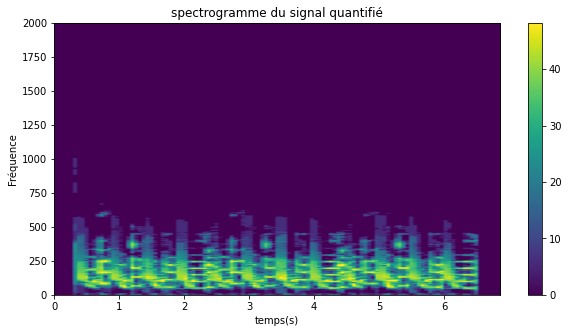

In [297]:
plt.figure(figsize=(10,5))
plt.imshow(20*np.log10(Xq+1-1e-10), aspect="auto", extent=(0,len(y)/Fe,0,Fe)) 
plt.title("spectrogramme du signal quantifié")
plt.xlabel("temps(s)")
plt.ylabel("Fréquence")
plt.colorbar()
plt.ylim(0,2000) 


In [298]:
def Fuquant_inv(xq,R):
    if R==0:
        return 0
    else :
        yq=np.round(xq)
        sign=-2*(yq//(2**(R-1)))+1
        Q=2/(2**R-1)
        x=yq%(2**(R-1))
        return sign*Q*x

In [299]:
# calcul de x déquantifié
x_décantif=np.zeros((x.shape[0],x.shape[1]))
for i in range (Xq.shape[0]):
    for j in range(Xq.shape[1]):
        x_décantif[i,j] = Fuquant_inv(abs(Xq[i,j]),Q[i,j])

# calcul de x dénormalisé
x_uq=np.zeros((x.shape[0],x.shape[1]))
for i in range (len(A)):
  x_uq[:,i]=x_décantif[:,i]*A[i]



In [301]:
def itfct(x_tfct,N_hop,N_fft,Fs):    
        
    # calcul du nombre de trames
    nbr_trames=x_tfct.shape[1] 
    
    # Préallocation de mémoire pour le signal y
    n=N_fft+(nbr_trames-1)*N_hop
    y=np.zeros(n,dtype=complex) 
    t=np.zeros(n)
    
    yl=np.zeros((N_fft,nbr_trames),dtype=complex)    
    for i in range (nbr_trames):
        yl[:,i]=np.fft.ifft(x_tfct[:,i])       
        
    # reconstruction de y_l
    y_tilde=np.zeros((n,nbr_trames),dtype=complex)
    
    for i in range (nbr_trames):
        y_tilde[i*N_hop:i*N_hop+N_fft,i]=yl[:,i]
        
    
    #création de l'axe temporel
    for i in range(n):
        t[i]=i/Fs
    
    for i in range(nbr_trames):
        y+=y_tilde[:,i]
    
    H = np.hamming(N_win)
    # normalisation
    k=0
    for i in range (N_win):
        k+=H[i]/N_hop    
     
    return y/k,t

N_fft=N_win

In [302]:
# reconstruction du signal debruité à partir du spectre complexe
x_denormalise_arg=np.zeros((x.shape[0],x.shape[1]),dtype=complex)
print(x_denormalise_arg.shape)
print(x.shape)


(10024, 117)
(10024, 117)


In [303]:
cmt=0
for i in range (x.shape[0]):
    for j in range (x.shape[1]):
        cmt+=1
        print(cmt)
        x_denormalise_arg[i,j]= (abs(x_uq)[i,j])*complex(np.cos(cmath.phase(x[i,j])),np.sin(cmath.phase(x[i,j])))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1167809
1167810
1167811
1167812
1167813
1167814
1167815
1167816
1167817
1167818
1167819
1167820
1167821
1167822
1167823
1167824
1167825
1167826
1167827
1167828
1167829
1167830
1167831
1167832
1167833
1167834
1167835
1167836
1167837
1167838
1167839
1167840
1167841
1167842
1167843
1167844
1167845
1167846
1167847
1167848
1167849
1167850
1167851
1167852
1167853
1167854
1167855
1167856
1167857
1167858
1167859
1167860
1167861
1167862
1167863
1167864
1167865
1167866
1167867
1167868
1167869
1167870
1167871
1167872
1167873
1167874
1167875
1167876
1167877
1167878
1167879
1167880
1167881
1167882
1167883
1167884
1167885
1167886
1167887
1167888
1167889
1167890
1167891
1167892
1167893
1167894
1167895
1167896
1167897
1167898
1167899
1167900
1167901
1167902
1167903
1167904
1167905
1167906
1167907
1167908
1167909
1167910
1167911
1167912
1167913
1167914
1167915
1167916
1167917
1167918
1167919
1167920
1167921
1167922
1167923
11

In [304]:
res,t=itfct(x_denormalise_arg,N_hop,N_fft,Fe)
display(Audio(res,rate=Fe))

/usr/local/lib/python3.7/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


(0.0, 2000.0)

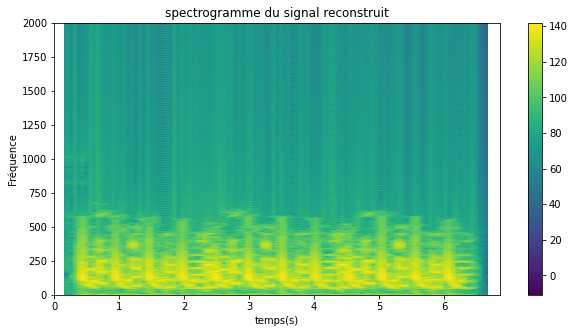

In [308]:
# spectrogramme du signal reconstitué
x_r,f,t=tfct('signal_reconstitue_392k.wav',N_win,N_hop,N_fft)

C=x_reconstruit.shape[1] # nombre de colonnes 
L=x_r.shape[0] # nombre de lignes   
    
# completer la matrice tfct
x_reconstruit=np.zeros((N_win,C),dtype=complex)

for i in range(C):
    x_reconstruit[0:L,i]=x_r[:,i]
  
for j in range (C):
    for i  in range(1,L):
        x_reconstruit[-i,j]=x_r[i-1,j].conjugate()

plt.figure(figsize=(10,5))
plt.imshow(20*np.log10(abs(x_reconstruit)), aspect="auto", extent=(0,len(y)/Fe,0,Fe))    
plt.title("spectrogramme du signal reconstruit")
plt.xlabel("temps(s)")
plt.ylabel("Fréquence")
plt.colorbar()
plt.ylim(0,2000)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1203321
1203322
1203323
1203324
1203325
1203326
1203327
1203328
1203329
1203330
1203331
1203332
1203333
1203334
1203335
1203336
1203337
1203338
1203339
1203340
1203341
1203342
1203343
1203344
1203345
1203346
1203347
1203348
1203349
1203350
1203351
1203352
1203353
1203354
1203355
1203356
1203357
1203358
1203359
1203360
1203361
1203362
1203363
1203364
1203365
1203366
1203367
1203368
1203369
1203370
1203371
1203372
1203373
1203374
1203375
1203376
1203377
1203378
1203379
1203380
1203381
1203382
1203383
1203384
1203385
1203386
1203387
1203388
1203389
1203390
1203391
1203392
1203393
1203394
1203395
1203396
1203397
1203398
1203399
1203400
1203401
1203402
1203403
1203404
1203405
1203406
1203407
1203408
1203409
1203410
1203411
1203412
1203413
1203414
1203415
1203416
1203417
1203418
1203419
1203420
1203421
1203422
1203423
1203424
1203425
1203426
1203427
1203428
1203429
1203430
1203431
1203432
1203433
1203434
1203435
12

/usr/local/lib/python3.7/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


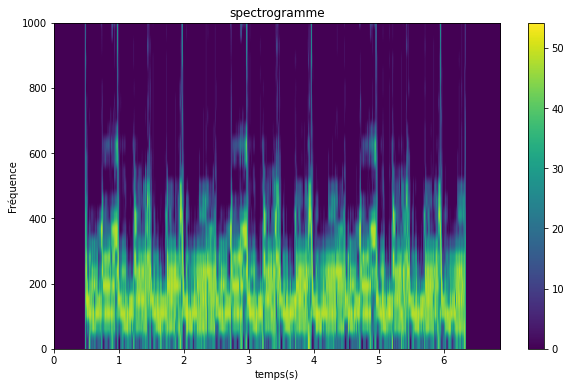

In [213]:
# test pour différents débits
debit1 = 1*(10**3)
trame_seconde = Fe/N_hop  #---nobre de trames par seconde
trame_seconde = trame_seconde + 1
bits_trame = int(debit1 / trame_seconde)
print(f"nombre des bits = {bits_trame}")

SMR = 20*np.log10(abs(x_norm+10**(-9)))+96

SNR = 0
NMR = SMR -SNR

Q = np.zeros((x_norm.shape[0],x_norm.shape[1])) 
NMR_1 = NMR
for i in range(NMR.shape[1]): #par trame
    R = bits_trame
    indice_max = np.argmax(NMR_1[:,i])    
    while ( R>0 and not (all(NMR_1[:,i]<0))):

      if (Q[indice_max,i]<=16):              
        indice_max = np.argmax(NMR_1[:,i])
        NMR_1[indice_max,i]-=6
        NMR[indice_max,i]-= 6
        Q[indice_max,i]=Q[indice_max,i]+ 1
        R = R - 1
            
      else:
        NMR_1[indice_max,i] = np.min(NMR_1[:,i])-100000
        indice_max = np.argmax(NMR_1[:,i])

Xq = np.zeros((x_norm.shape[0],x_norm.shape[1]))
for i in range (x_norm.shape[0]):
    for j in range(x_norm.shape[1]):
        Xq[i,j] = Fuquant(abs(x_norm[i,j]),Q[i,j])

plt.figure(figsize=(10,6))
plt.imshow(20*np.log10(Xq+1-1e-10), aspect="auto", extent=(0,len(y)/Fe,0,Fe)) 
plt.title("spectrogramme")
plt.xlabel("temps(s)")
plt.ylabel("Fréquence")
plt.colorbar()
plt.ylim(0,1000) 
print(np.min(Xq))

# calcul de x déquantifié
x_décantif=np.zeros((x.shape[0],x.shape[1]))
for i in range (Xq.shape[0]):
    for j in range(Xq.shape[1]):
        x_décantif[i,j] = Fuquant_inv(abs(Xq[i,j]),Q[i,j])

# calcul de x dénormalisé
x_denormalise=np.zeros((x.shape[0],x.shape[1]))
for i in range (len(A)):
  x_denormalise[:,i]=x_décantif[:,i]*A[i]

# reconstruction du signal debruité à partir du spectre complexe
x_denormalise_arg=np.zeros((x.shape[0],x.shape[1]),dtype=complex)
print(x_denormalise_arg.shape)
print(x.shape)

cmt=0
for i in range (x.shape[0]):
    for j in range (x.shape[1]):
        cmt+=1
        print(cmt)
        x_denormalise_arg[i,j]= (abs(x_denormalise)[i,j])*complex(np.cos(cmath.phase(x[i,j])),np.sin(cmath.phase(x[i,j])))

res,t=itfct(x_denormalise_arg,N_hop,N_fft,Fe)
display(Audio(res,rate=Fe))